<div style="display: flex; gap: 10px;">
  <img src="../images/HOOPS_AI.jpg" style="width: 20%;">
   

In [1]:
import hoops_ai
import os

hoops_ai.set_license(hoops_ai.use_test_license(), validate= False)

ℹ️ Using TEST LICENSE (expires January 31, 2026 - 7 days remaining)
   For production use, obtain your own license from Tech Soft 3D
HOOPS AI version :  1.0.0-b2dev1 



In [2]:
import pathlib, sys
sys.path.insert(0, str( pathlib.Path.cwd()))
import importlib
import helper_tutorials  
importlib.reload(helper_tutorials)  # Forces reload of the latest version

<module 'helper_tutorials' from 'C:\\Users\\LuisSalazar\\MAIN\\repos\\HOOPS-AI-tutorials\\notebooks\\helper_tutorials.py'>

# HOOPS AI: Using a Pre-trained Model

In this tutorial, we will use a pre-trained model to detect machine features. The model was trained using HOOPS AI, specifically using the pre-built architecture of GraphNodeClassification. The dataset contained more than 160,000 cad files and the splitting is as follows: 

Train set contains          : 113878 samples (70.12%)
Validation set contains     : 24220 samples (14.91%)
Test set contains           : 24311 samples (14.97%)
Total samples               : 162409

The model reported a IoU (Intersection of union) accuracy of 98.9% on the test set.

The dataset consists of synthetic samples describing the features (cadsynth dataset) and sample using features intersected (mfinst dataset). Both dataset are public.

<div style="display: flex; gap: 10px;">
  <img src="../images/features_sampling_dataset.png" style="width: 50%;">
  <img src="../images/features_intersection_dataset.png" style="width: 50%;">
</div>


Then, the model was tested on unseen data, real samples parts. The model was able to detect some features in real cases proving that besides simple trained data the model could learn how to detect the features.





In [3]:

import pathlib
import json

# Define paths 
demofile_dir  = pathlib.Path.cwd().parent.joinpath("packages", "cadfiles")
output_dir    = pathlib.Path.cwd().joinpath("out")
cad_file_test = str(demofile_dir.joinpath("nist_ftc_06_asme1_rd_sw1802.SLDPRT")) # largest_mftrcad.step
#cad_file_test = str(demofile_dir.joinpath("largest_mftrcad.step")) # 


In [4]:
from hoops_ai.cadaccess import HOOPSLoader
from hoops_ai.insights import CADViewer

# Initialize CAD loader (needed for ML inference later)
loader = HOOPSLoader()

# Create viewer and load CAD file (auto-converts to SCS and displays in sidecar)
viewer = CADViewer(display_mode='sidecar', silent=True, static_folder=output_dir)
viewer.load_cad_file(cad_file_test, auto_convert=True, white_background=True)



True

In [5]:
viewer.show()

# ML prediction 

The `FlowInference` class handles inference with trained models. It provides methods for preprocessing CAD data, making predictions, and post-processing results.

## Transform the CAD data into machine learning input data

- load the trained modle from the checkpoint file and instantiate using the respective FlowModel
- Initialize HoopsLoader to read the cad file
- preprocess the cad file to encode its data according to the expected ml architecture

In [6]:
from hoops_ai.ml.EXPERIMENTAL import FlowInference
from hoops_ai.ml.EXPERIMENTAL import GraphNodeClassification

trained_model = pathlib.Path.cwd().parent.joinpath("packages","trained_ml_models", "ts3d_162k_mfr.ckpt")

inference_model = FlowInference(cad_loader = loader, flowmodel = GraphNodeClassification(result_dir=output_dir))
inference_model.load_from_checkpoint(trained_model)

Successfully loaded model from checkpoint: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\packages\trained_ml_models\ts3d_162k_mfr.ckpt


We choose for the inference test a file from the NIST list. 

In [7]:
ml_input = inference_model.preprocess(cad_file_test)    
predictions, probabilities = inference_model.predict_and_postprocess(ml_input)
print(predictions)


[ 0  0 22 22 22  0  0  0 22 22 22 17  0  0 22 22 22  0  0 17  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0
  1  2  2  1  3 17 23 23 17 23 23 17 23 23 17 23 23  0  0 22 22 22 22 22
 22  0  0 22 22 22  2  1  2  1  3  0  0 17 17 17 17 17 17 17  0 16 24 24
 24 24 24 24  0  0  0 19 24 19  0  0  0  0 12 21 21 21 21 21 21 21 12 12
 12 12 12 21 21 21 21 21 21 21 21 21 21 21 21 21 21 12 21 21 21 21 21 21]


# Visualize Predictions on CAD Model

Now that we have predictions for each face, we'll use the **HOOPS AI Insights** module to visualize them on the 3D model.

## Step 1: Create a Color Palette

We use `ColorPalette` to map each manufacturing feature label to a unique color and description. We can optionally reserve specific colors for important features (e.g., red for through holes).


In [8]:
from hoops_ai.insights.utils import ColorPalette

# Define label descriptions
labels_description = {
    0: "no-label", 1: "rectangular_through_slot", 2: "triangular_through_slot", 3: "rectangular_passage",
    4: "triangular_passage", 5: "6sides_passage", 6: "rectangular_through_step", 7: "2sides_through_step",
    8: "slanted_through_step", 9: "rectangular_blind_step", 10: "triangular_blind_step", 
    11: "rectangular_blind_slot", 12: "rectangular_pocket", 13: "triangular_pocket", 14: "6sides_pocket",
    15: "chamfer", 16: "circular through slot", 17: "through hole", 18: "circular blind step",
    19: "horizontal circular end blind slot", 20: "vertical circular end blind slot", 
    21: "circular end pocket", 22: "o-ring", 23: "blind hole", 24: "fillet"
}

# Create color palette with maximally distinct colors (use_distinct_colors=True by default)
color_palette = ColorPalette.from_labels(
    labels_description,
    reserved_colors={
        0: (200, 200, 200),  # Gray for background
    }
)

print(f"Created color palette for {len(color_palette)} labels")
print(f"Sample: Label 17 -> Color {color_palette.get_color(17)}, Description: '{color_palette.get_description(17)}'")
print(f"Sample: Label 22 -> Color {color_palette.get_color(22)}, Description: '{color_palette.get_description(22)}'")
print(f"Sample: Label 23 -> Color {color_palette.get_color(23)}, Description: '{color_palette.get_description(23)}'")
#help(ColorPalette)

Created color palette for 25 labels
Sample: Label 17 -> Color (89, 51, 21), Description: 'through hole'
Sample: Label 22 -> Color (24, 87, 242), Description: 'o-ring'
Sample: Label 23 -> Color (135, 191, 57), Description: 'blind hole'


### Understanding the Workflow

The visualization workflow has two main steps:

**1. Group predictions by label:**
```python
face_groups = group_predictions_by_label(predictions, color_palette, exclude_labels={0})
```
This returns a list of `(face_indices, color, description)` tuples, one for each unique label.

**2. Color the faces:**
```python
viewer.color_faces_by_groups(face_groups, delay=0.5, verbose=True)
```
This colors all face groups with animated progress feedback.

**Manual approach (if you need full control):**
```python
viewer.clear_face_colors()
for face_indices, color, description in face_groups:
    viewer.set_face_color(face_indices, list(color))
    print(f"{description}: {len(face_indices)} faces")
```


## Step 2: Group Predictions and Visualize

Now we visualize the predictions using three simple lines:
1. **Group** faces by their predicted label using `group_predictions_by_label()`
2. **Visualize** on the viewer using `color_faces_by_groups()`
3. Enjoy **animated coloring** with progress feedback!


In [9]:
import hoops_ai

# Group faces by prediction label and attach colors/descriptions
face_groups = hoops_ai.insights.utils.group_predictions_by_label(predictions, color_palette, exclude_labels={})

# Visualize on the viewer
viewer.color_faces_by_groups(face_groups, delay=0.5, verbose=True)
all_zero_faces = [i for i,v in enumerate(predictions) if v==0]
viewer.set_face_color(all_zero_faces, [255, 255, 255])

   no-label (50 faces)
   o-ring (18 faces)
   through hole (14 faces)
   rectangular_through_slot (4 faces)
   triangular_through_slot (4 faces)
   rectangular_passage (2 faces)
   blind hole (8 faces)
   circular through slot (1 faces)
   fillet (7 faces)
   horizontal circular end blind slot (2 faces)
   rectangular_pocket (7 faces)
   circular end pocket (27 faces)


In the Hoops viewer, you can see how the features detected are projected in the cad file

<img src="../images/nist_predictions.png" style="width: 40%;">

In [10]:
print(predictions)

[ 0  0 22 22 22  0  0  0 22 22 22 17  0  0 22 22 22  0  0 17  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0
  1  2  2  1  3 17 23 23 17 23 23 17 23 23 17 23 23  0  0 22 22 22 22 22
 22  0  0 22 22 22  2  1  2  1  3  0  0 17 17 17 17 17 17 17  0 16 24 24
 24 24 24 24  0  0  0 19 24 19  0  0  0  0 12 21 21 21 21 21 21 21 12 12
 12 12 12 21 21 21 21 21 21 21 21 21 21 21 21 21 21 12 21 21 21 21 21 21]


In [11]:
from hoops_ai.cadaccess import HOOPSLoader, HOOPSModel, HOOPSTools
from hoops_ai.cadencoder import BrepEncoder

cad_model = loader.create_from_file(str(cad_file_test))
# Adapt to extract BRep information
hoopstools  = HOOPSTools()
hoopstools.adapt_brep(cad_model)
brep_encoder = BrepEncoder(cad_model.get_brep())

In [12]:
[face_types, face_areas, face_loops], face_types_descr = brep_encoder.push_face_attributes()
face_discretization = brep_encoder.push_face_discretization(pointsamples=24)
print("face_types_descr", face_types_descr)

face_types_descr {0: 'Plane', 1: 'Cylinder', 2: 'Cone', 3: 'Sphere', 4: 'Torus'}


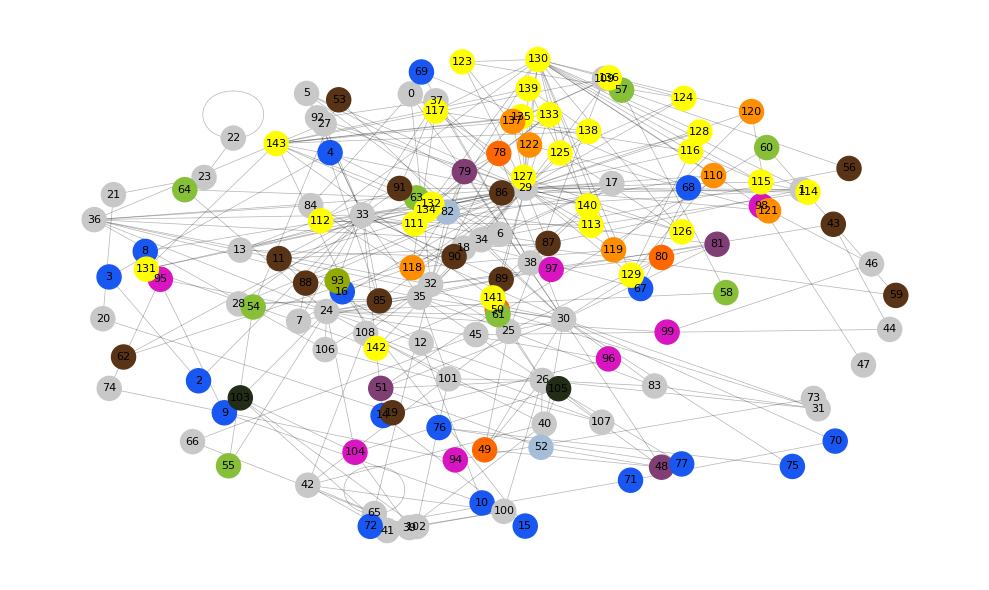

In [13]:
adj_graph = brep_encoder.push_face_adjacency_graph()
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

G = adj_graph
n = G.number_of_nodes()

pos = nx.spring_layout(adj_graph, k=0.5, seed=42)

nodes = list(G.nodes())  # order used for coloring
to01 = lambda rgb: tuple(c/255 for c in rgb)

node_colors = [to01(color_palette.get_color(predictions[i])) for i in range(len(nodes))]

plt.figure(figsize=(10, 6))
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, arrows=False)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
nx.draw_networkx_labels(G, pos, labels={n: str(n) for n in nodes}, font_size=8)

plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
face_index = 58 # in green
neighbor_faces = set(adj_graph.successors(face_index)) | set(adj_graph.predecessors(face_index))
print(neighbor_faces)

{24, 57}


In [15]:
print("face types:", face_types_descr[face_types[58]], "-> face area:", face_areas[58])
face_sampling_coordinates = face_discretization[58,:,:3]
face_sampling_normals = face_discretization[58,:,3:6]
print("some face_sampling_coordinates" ,  face_sampling_coordinates[:3])
print("some face_sampling_normals" ,  face_sampling_normals[:3])

face types: Cylinder -> face area: 633.13
some face_sampling_coordinates [[-0.13335    0.01778   -0.1762125]
 [-0.13335    0.020828  -0.1762125]
 [-0.13335    0.023876  -0.1762125]]
some face_sampling_normals [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [16]:
viewer.terminate()